In [2]:
# Tensorflow와 Tensoflow Hub에 있는 이미 학습된 모델을 활용하기 위한 모듈 
import tensorflow as tf
import tensorflow_hub as hub

# 이미지를 다운로드하는 데에 사용하는 모듈
import matplotlib.pyplot as plt
import tempfile 
from six.moves.urllib.request import urlopen
from six import BytesIO

# 이미지에 선과 폰트를 넣기 위한 모듈
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# Detection하는 데에 소요된 시간을 점검하기 위한 모듈
import time

In [3]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [4]:
def download_and_resize_image(url, new_width=256, new_height=256, display=False): 
  
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)  # 이미지 읽기
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS) # 이미지 조정
  pil_image_rgb = pil_image.convert("RGB") #RBG로 변환
  pil_image_rgb.save(filename, format="JPEG", quality=90) # 이미지 저장
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

In [5]:
def draw_bounding_box_on_image(image, 
                               ymin, xmin, ymax, xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)

# BBox 테두리 그리기
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

In [42]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1): 
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

# BBox 그리기 적용
  for i in range(min(boxes.shape[0], max_boxes)):
    if (scores[i] >= min_score).any():
      ymin, xmin, ymax, xmax = tuple(boxes[i])  # 박스 좌표값
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Image downloaded to /tmp/tmpk1uysnoe.jpg.


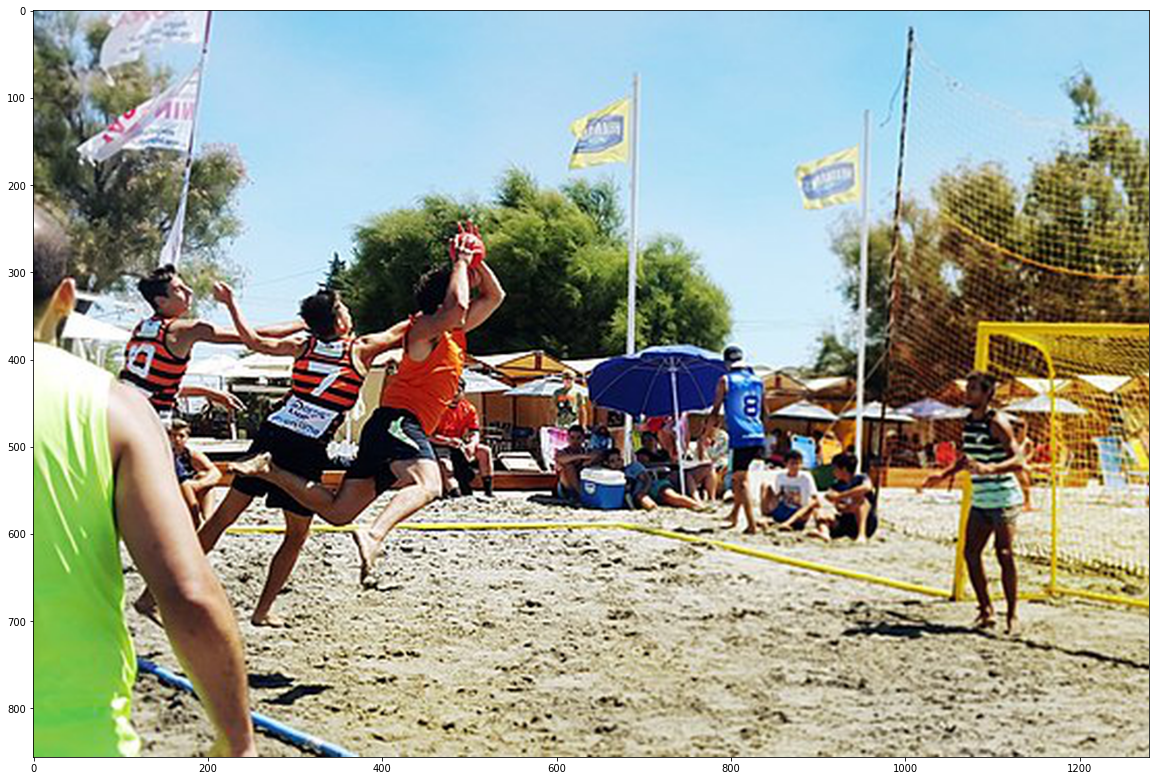

In [7]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Torneo_beach_handball.jpg/640px-Torneo_beach_handball.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)  

In [18]:
module_handle = "https://www.kaggle.com/models/tensorflow/efficientdet/TensorFlow2/d0/1"

detector = hub.load(module_handle)

In [12]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [44]:
def run_detector(detector, path):
  img = load_img(path) 

  converted_img  = tf.image.convert_image_dtype(img, tf.uint8)[tf.newaxis, ...]

# 소요시간 측정
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

# 이미지 추론 개수와 추론 시간 출력
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

# 이미지 내 박스로 entity, scores를 추가하여 출력

  display_image(converted_img)

In [35]:
detector_output = detector(converted_img)
class_ids = detector_output["detection_classes"]

In [46]:
detector_output

{'raw_detection_boxes': <tf.Tensor: shape=(1, 49104, 4), dtype=float32, numpy=
 array([[[ 0.3206446 ,  0.00601861,  0.4170839 ,  0.00601861],
         [ 0.00599715,  0.00755105,  0.03317289,  0.04158497],
         [-0.00922444, -0.02979923,  0.05325467,  0.03183888],
         ...,
         [ 0.3511321 ,  0.5004616 ,  1.4628015 ,  1.1574565 ],
         [ 0.25280857,  0.41783324,  1.6677866 ,  1.1744955 ],
         [-0.1138224 ,  0.23770577,  1.8461955 ,  1.2576301 ]]],
       dtype=float32)>,
 'raw_detection_scores': <tf.Tensor: shape=(1, 49104, 90), dtype=float32, numpy=
 array([[[1.9036418e-01, 2.9814223e-02, 9.8223738e-02, ...,
          5.6545786e-03, 4.7603073e-03, 7.8712013e-03],
         [8.8641793e-03, 1.5931089e-03, 5.0287074e-03, ...,
          4.5407456e-04, 8.9838903e-04, 6.7125837e-04],
         [5.0908321e-04, 1.4096210e-04, 2.6249222e-04, ...,
          2.8244389e-05, 3.3109201e-04, 7.2871015e-05],
         ...,
         [3.9166948e-03, 9.0849056e-04, 1.1453481e-03, ...,
